In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation
import h5py
from sklearn.cluster import DBSCAN
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes',labelsize=10) 
locs = ['sector001_camera1_ccd1', 'sector001_camera1_ccd2', 'sector001_camera1_ccd4','sector001_camera3_ccd1']
loc = locs[1]
ddir = '/Users/Oliver/PhD/TASOC/TESS_data/'+loc+'.hdf5'
title = 'TESS '+loc.replace('_',' ')
title

'TESS sector001 camera1 ccd2'

## TODO: Iterate the sumimage to remove any sharp features?

In [2]:
f = h5py.File(ddir, 'r', libver='latest')

In [3]:
indices = np.array(list(f['backgrounds']))[::25]

Important note:
I am only checking the functionality as it appears in the `photometry` `backgrounds.py` code, and not worrying about smoothing in time.

## Create the function calls for the different image states

In [4]:
def get_bkg(idx):
    return np.array(f['backgrounds'][idx])

def get_logbkg(idx):
    return np.log10(get_bkg(idx) + np.abs(bkgmin) + 1)

def get_image(idx):
    return np.array(f['backgrounds'][idx]) + np.array(f['images'][idx])

def get_logimage(idx):
    return np.log10(get_image(idx) + np.abs(imamin) + 1)

def get_corr(idx):
    return np.array(f['images'][idx])

def get_logcorr(idx):
    return np.log10(get_corr(idx) + np.abs(cormin) + 1)

In [5]:
cormin = np.array([np.nanmin(np.array(f['images'][idx])) for idx in indices]).min()
bkgmin = np.array([np.nanmin(np.array(f['backgrounds'][idx])) for idx in indices]).min()
imamin = np.array([np.nanmin(get_image(idx)) for idx in indices]).min()
sumimage = np.array(f['sumimage'])

# Plot the first frame for testing

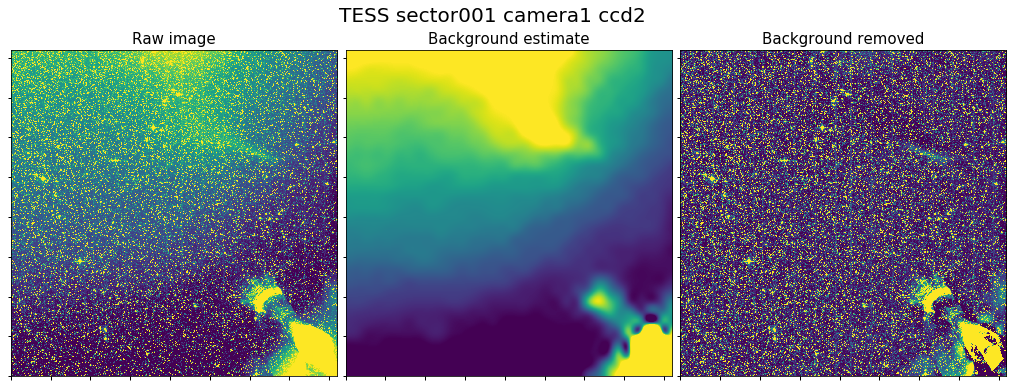

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle(title,fontsize=20)

gs = gridspec.GridSpec(1, 3, figure=fig,wspace=0, hspace=0)
ax1 = plt.subplot(gs[:, :1])
ax2 = plt.subplot(gs[:, 1:2])
ax0 = plt.subplot(gs[:, 2:])


im0 = ax0.imshow(get_logcorr('0000'), origin='lower',
                 vmin = np.nanpercentile(get_logcorr('0000'),[10]), vmax = np.nanpercentile(get_logcorr('0000'), [90]))
im = ax1.imshow(get_logimage('0000'), origin='lower',
                vmin=np.nanpercentile(get_logimage('0000'),[10]), vmax=np.nanpercentile(get_logimage('0000'), [90]))
im2 = ax2.imshow(get_logbkg('0000'), origin='lower', 
                 vmin=np.nanpercentile(get_logbkg('0000'),[10]), vmax=np.nanpercentile(get_logbkg('0000'), [90]))
                                   
ax0.set_title('Background removed',fontsize=15)    
ax1.set_title('Raw image',fontsize=15)
ax2.set_title('Background estimate',fontsize=15)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.show()

## Lets write a function to flag bad pixels

## The difference image we're working with :
The idea is that averaged over the sector, sharp features shouldn't be visible. If there are any in an individual frame, they will stick out like a sore thumb.

In [7]:
from tqdm import tqdm

def get_sumimage():
    shape = np.array(f['images']['0000']).shape
    sumimage = np.zeros((len(indices),shape[0], shape[1]))
    for i, idx in tqdm(enumerate(indices)):
        sumimage[i] = get_corr(idx)
    sumimage = np.median(sumimage, axis=0)
    return sumimage
sumimage = get_sumimage()

52it [00:06,  7.64it/s]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


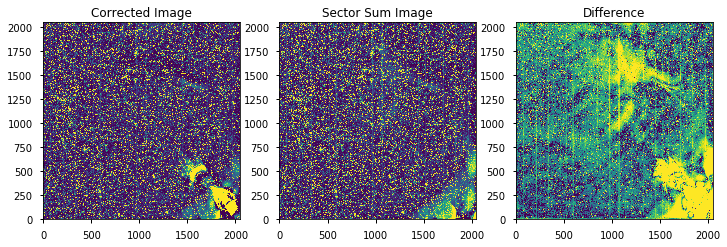

In [8]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
diffimage = np.abs(get_corr('0000') - sumimage)
logsumimage = np.log10(sumimage + np.abs(np.nanmin(sumimage)) + 1)
logdiffimage = np.log10(diffimage)

ax[0].imshow(get_logcorr('0000'), origin='lower',
                 vmin = np.nanpercentile(get_logcorr('0000'),[10]), vmax = np.nanpercentile(get_logcorr('0000'), [90]))
ax[1].imshow(logsumimage, origin='lower',
                 vmin = np.nanpercentile(logsumimage,[10]), vmax = np.nanpercentile(logsumimage, [90]))
ax[2].imshow(logdiffimage, origin='lower',
                 vmin = np.nanpercentile(logdiffimage,[10]), vmax = np.nanpercentile(logdiffimage, [90]))
ax[0].set_title('Corrected Image')
ax[1].set_title('Sector Sum Image')
ax[2].set_title('Difference')
plt.show()


## Lets see how different masks mask broken features

In [9]:
def madmodemask(diffim, madfraction=.5):
    per = diffim < np.nanpercentile(diffim, [90])
    nan = np.isfinite(diffim[per])

    kde = stats.gaussian_kde(diffim[per][nan], bw_method='scott')
    alpha = np.linspace(np.nanmin(diffim[per]), np.nanmax(diffim[per]), 100)
    mode = alpha[np.argmax(kde(alpha))]
    mad = robust.scale.mad(diffim[per][nan].flatten())
    return (diffim>(mode+mad*madfraction))

def percentilemask(diffim, percentile=95):
    return (diffim > np.nanpercentile(diffim,[percentile]))

def dbscanmask(diffimage, eps = np.sqrt(2), cutoff=2500, return_veil=True):
    NX, NY = diffimage.shape
    X, Y = np.meshgrid(np.arange(NX), np.arange(NY))

    #initiating the dbscan parameters
    sel = madmodemask(diffimage)  #Start by masking using the MAD Mode method
    x = np.zeros([len(diffimage[sel]), 2], dtype=int)
    x[:,0] = X[sel]
    x[:,1] = Y[sel]

    #Run DBSCAN
    db = DBSCAN(eps = np.sqrt(2), min_samples=8).fit(x)
    labels = db.labels_
    unique_labels = np.unique(labels)

    #Output the cluster information
    veil = np.zeros(X.shape)
    veil -= 1
    ns = np.array([len(np.where(labels==k)[0]) for k in unique_labels])
    for k in unique_labels[ns > cutoff]:
        if k != -1:
            veil[x[labels==k][:,1], x[labels==k][:,0]] = k
    veil[veil==-1] = np.nan
    nanmask = np.isfinite(veil)

    if return_veil:
        return nanmask, veil
    else:
        return nanmask

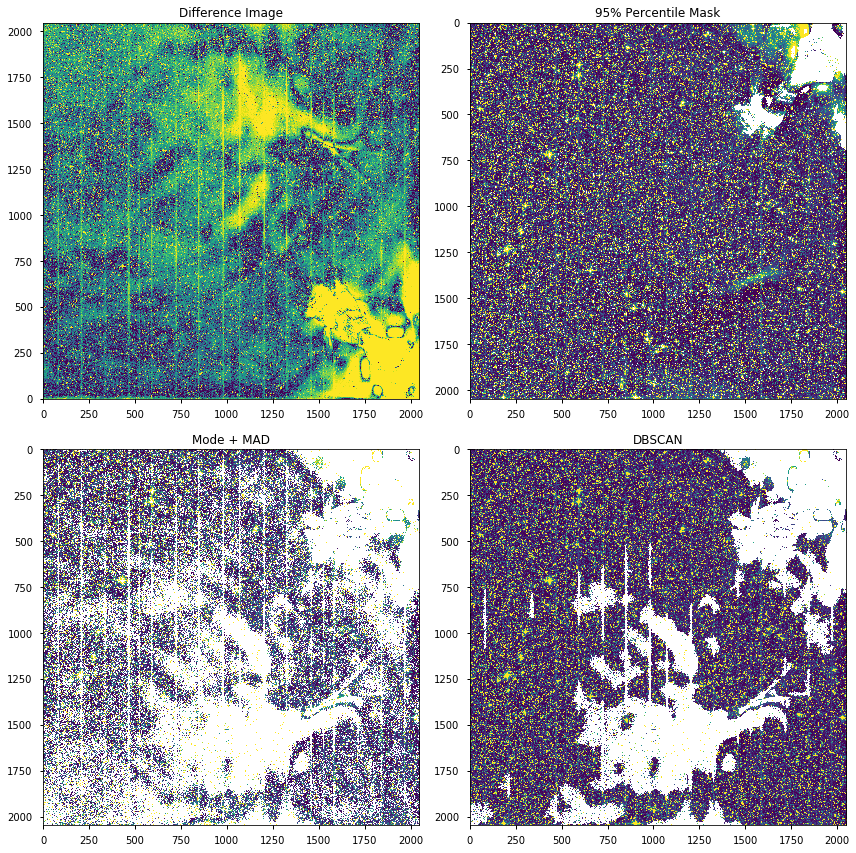

In [10]:
from scipy import stats
from statsmodels import robust

fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].imshow(logdiffimage, origin='lower',
             vmin = np.nanpercentile(logdiffimage,[10]), vmax = np.nanpercentile(logdiffimage, [90]))
ax[0,0].set_title('Difference Image')

im = get_logcorr('0000')
im[percentilemask(diffimage)] = np.nan
ax[0,1].imshow(im, vmin = np.nanpercentile(im,[10]), vmax = np.nanpercentile(im, [90]))
ax[0,1].set_title('95% Percentile Mask')

im = get_logcorr('0000')
im[madmodemask(diffimage, madfraction=0.5)] = np.nan
ax[1,0].imshow(im, vmin = np.nanpercentile(im,[10]), vmax = np.nanpercentile(im, [90]))
ax[1,0].set_title('Mode + MAD')
fig.tight_layout()

im = get_logcorr('0000')
im[dbscanmask(diffimage, return_veil = False)] = np.nan
ax[1,1].imshow(im, vmin = np.nanpercentile(im,[10]), vmax = np.nanpercentile(im, [90]))
ax[1,1].set_title('DBSCAN')
fig.tight_layout()
plt.show()

## Invetigating the DBSCAN method

We want to add the edges also!
Make arbitrary cut off to avoid stars

In [11]:
mask, veil = dbscanmask(diffimage,eps=100)

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
ax1.imshow(veil,cmap='Set1')

test = get_logcorr('0000')
test[mask] = np.nan
ax2.imshow(test, vmin=np.nanpercentile(test,[10]), vmax=np.nanpercentile(test, [90]))
plt.show()

# Make the movie

In [15]:
def get_maskcorr(idx):
    corr =  np.array(f['images'][idx])
    mask = percentilemask(diffimage, percentile=90)
    corr[mask] = np.nan
    return corr

def get_masklogcorr(idx):
    return np.log10(get_maskcorr(idx) + np.abs(cormin) + 1)

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle(title,fontsize=20)

gs = gridspec.GridSpec(1, 3, figure=fig,wspace=0, hspace=0)
ax1 = plt.subplot(gs[:, :1])
ax2 = plt.subplot(gs[:, 1:2])
ax0 = plt.subplot(gs[:, 2:])


im0 = ax0.imshow(get_masklogcorr('0000'), animated=True, origin='lower',
                 vmin = np.nanpercentile(get_masklogcorr('0000'),[10]), vmax = np.nanpercentile(get_masklogcorr('0000'), [90]))
im = ax1.imshow(get_image('0000'), animated=True, origin='lower',
                vmin=np.nanpercentile(get_logbkg('0000'),[10]), vmax=np.nanpercentile(get_logbkg('0000'), [90]))
im2 = ax2.imshow(get_bkg('0000'), animated=True, origin='lower', 
                 vmin=np.nanpercentile(get_logbkg('0000'),[10]), vmax=np.nanpercentile(get_logbkg('0000'), [90]))

divider = make_axes_locatable(ax0)
cax2 = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im2, cax=cax2,label=r'$\log_{10}(Flux)$')
                                   
ax0.set_title('Background removed',fontsize=15)    
ax1.set_title('Raw image',fontsize=15)
ax2.set_title('Background estimate',fontsize=15)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

def updatefig(idx):
    im0.set_array(get_masklogcorr(idx))
    im.set_array(get_logimage(idx))
    im2.set_array(get_logbkg(idx))
    return im, im2,             
    
ani = animation.FuncAnimation(fig, updatefig, frames=indices,
                             blit=True, repeat=True, interval = 500)
plt.close(fig)
HTML(ani.to_html5_video())

In [14]:
ani.save(loc+'.gif', dpi=1080, writer='pillow')

In [ ]:
sys.exit()

### A fun test as an aside

In [ ]:
locs = ['sector001_camera1_ccd1', 'sector001_camera1_ccd2', 'sector001_camera1_ccd4','sector001_camera3_ccd1']


In [ ]:
from tqdm import tqdm

for loc in locs:
    ddir = '/Users/Oliver/PhD/TASOC/TESS_data/'+loc+'.hdf5'
    title = 'TESS '+loc.replace('_',' ')
    f = h5py.File(ddir, 'r', libver='latest')
    
    flux = np.zeros(len(list(f['backgrounds'])))
    for idx, i in tqdm(enumerate(list(f['backgrounds']))):
        flux[idx] = np.sum(f['backgrounds'][i])
    time = np.array(f['time'])
    np.savetxt('../TESS_data/'+loc+'.txt',list(zip(time,flux)))

In [ ]:
t111, f111 = np.genfromtxt('../TESS_data/'+locs[0]+'.txt').T
t112, f112 = np.genfromtxt('../TESS_data/'+locs[1]+'.txt').T
t112, f112 = np.genfromtxt('../TESS_data/'+locs[1]+'.txt').T
t131, f131 = np.genfromtxt('../TESS_data/'+locs[2]+'.txt').T

In [ ]:
from lightkurve import LightCurve
from astropy import units as u
lc111 = LightCurve(t111[:-20], f111[:-20]).normalize().flatten()
lc112 = LightCurve(t112[:-20], f112[:-20]).normalize().flatten()
lc131 = LightCurve(t131[:-20], f131[:-20]).normalize().flatten()

pg111 = lc111.to_periodogram(max_frequency=6)
pg112 = lc112.to_periodogram(max_frequency=6)
pg131 = lc131.to_periodogram(max_frequency=6)

In [ ]:
ax = lc111.plot(label = locs[0])
lc112.plot(ax=ax, label=locs[1])
lc131.plot(ax=ax, label=locs[2])
ax.legend()
ax.set_title('Normalized, Detrended')
plt.show()

ax = pg111.plot(label=locs[0])
pg112.plot(ax=ax, label=locs[1])
pg131.plot(ax=ax,label=locs[2])
# ax.axvline(1/0.5, linewidth=1, alpha=.5, c='r', label='0.5 day period')
# ax.axvline(1/(27/2), linewidth=1, alpha=.5, label='half sector period')
ax.set_title('Normalized, Detrended')
ax.legend()
plt.show()

# Graveyard

## Using our own changed background

### Resolution isn't going to solve this issue using the SExtractor method